In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , GlobalMaxPooling1D , Input , MaxPooling1D , Conv1D , Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 1

In [4]:
print('Loading word vectors...')
word2vec = {}

with open(os.path.join('E:/Datasets/Globe6B/glove.6B.%sd.txt' % EMBEDDING_DIM) , encoding = 'utf8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:] , dtype = 'float32')
        word2vec[word] = vec
    
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [5]:
print('Loading in comments...')

train = pd.read_csv("E:/Datasets/Toxic comment/train.csv" , engine = 'python')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
 
possible_labels = ["toxic" , "severe_toxic" , "obscene" , "threat" , "insult" , "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [6]:
targets

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [7]:
sentences

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [8]:
train.head(8)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0


In [9]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [10]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))

s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [11]:
# get word -> integer mapping

word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210496 unique tokens.


In [12]:
data = pad_sequences(sequences , maxlen = MAX_SEQUENCE_LENGTH)
print("Shape of data tensor: " , data.shape)

Shape of data tensor:  (159571, 100)


In [13]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [14]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [ 0.090655  ,  0.92672002, -0.45091999, ...,  0.077208  ,
        -0.12886   ,  0.18616   ],
       [ 0.17364   ,  0.029917  , -0.057949  , ..., -0.30632001,
        -0.064848  ,  0.025999  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [15]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable = False)

In [16]:
print("Building Model.........")

input_ = Input(shape = (MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128 , 3 , activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128 , 3 , activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128 , 3 , activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128 , activation = 'relu')(x)
output = Dense(len(possible_labels) , activation = 'sigmoid')(x)

Building Model.........


In [17]:
model = Model(input_ , output)
model.compile(loss = 'binary_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'])

In [18]:
print('Training model...')

r = model.fit(
  data,
  targets,
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_split = VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/1
127656/127656 [==============================] - 56s 435us/step - loss: nan - accuracy: 0.0390 - val_loss: nan - val_accuracy: 0.0365


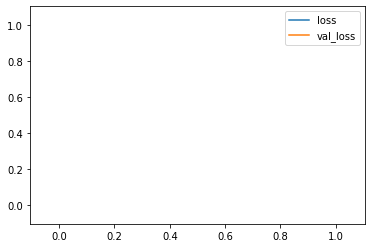

In [19]:
# plot some data
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

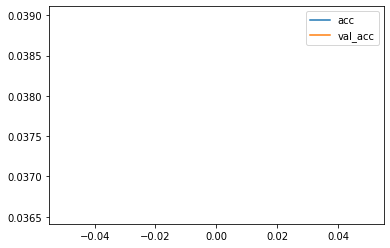

In [20]:
# accuracies
plt.plot(r.history['accuracy'], label = 'acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()

In [21]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').